In [3]:
from sklearn.feature_extraction.text import CountVectorizer

import beautifultools as bt
import pandas as pd
import wordcloud as wc
import pickle
import qgrid
import os.path

# Scraping for Scouting
## An intergalactic guide on how to leverage prospect web-page information

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#An-intergalactic-guide-on-how-to-leverage-prospect-web-page-information" data-toc-modified-id="An-intergalactic-guide-on-how-to-leverage-prospect-web-page-information-1">An intergalactic guide on how to leverage prospect web-page information</a></span></li><li><span><a href="#Objective" data-toc-modified-id="Objective-2">Objective</a></span></li><li><span><a href="#Data-gathering-process" data-toc-modified-id="Data-gathering-process-3">Data gathering process</a></span></li><li><span><a href="#Exploratory-analysis" data-toc-modified-id="Exploratory-analysis-4">Exploratory analysis</a></span><ul class="toc-item"><li><span><a href="#Distribution-of-keywords-by-customer-and-prospect" data-toc-modified-id="Distribution-of-keywords-by-customer-and-prospect-4.1">Distribution of keywords by customer and prospect</a></span></li><li><span><a href="#A-glimpse-on-the-distribution" data-toc-modified-id="A-glimpse-on-the-distribution-4.2">A glimpse on the distribution</a></span></li><li><span><a href="#Let's-normalize:-stemming" data-toc-modified-id="Let's-normalize:-stemming-4.3">Let's normalize: stemming</a></span></li></ul></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-5">Modelling</a></span><ul class="toc-item"><li><span><a href="#Step-1:-Feature-selection" data-toc-modified-id="Step-1:-Feature-selection-5.1">Step 1: Feature selection</a></span></li><li><span><a href="#Step-2:-Topic-modelling" data-toc-modified-id="Step-2:-Topic-modelling-5.2">Step 2: Topic modelling</a></span></li><li><span><a href="#Step-3:-Scoring-on-webpage" data-toc-modified-id="Step-3:-Scoring-on-webpage-5.3">Step 3: Scoring on webpage</a></span></li></ul></li><li><span><a href="#Applying-the-model" data-toc-modified-id="Applying-the-model-6">Applying the model</a></span><ul class="toc-item"><li><span><a href="#Training-test-split" data-toc-modified-id="Training-test-split-6.1">Training-test split</a></span></li><li><span><a href="#Crossvalidating-parameters" data-toc-modified-id="Crossvalidating-parameters-6.2">Crossvalidating parameters</a></span></li><li><span><a href="#Out-of-sample-model-performance" data-toc-modified-id="Out-of-sample-model-performance-6.3">Out of sample model performance</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-7">Conclusion</a></span></li></ul></div>

## Objective
Use the information contained in the home pages of Siemens customers and potential ones to train an algorithm that outputs a sentiment $p = [0,1]$ on new potential prospects home pages.

## Data gathering process

In [4]:
# Save/load the file based on its existence
if os.path.isfile("data/webpageTokens.pickle"):
    print("Loading file")
    with open("data/webpageTokens.pickle", "rb") as fp:  # UnPickling
        df = pickle.load(fp)

else:
    # Parse data from spreadsheets
    prospect = pd.read_excel("output/Prospect_Ranking_NoCompetitor.xlsx")

    client = pd.read_excel("data/Master TEMPLATE_DF-PD_2019_8_MARCO.xlsx",
                           sheet_name="Master Template")

    # Evaluate 2018-2017-2016 mean orders
    client["Orders Mean"] = client[[
        "Orders 18 DF_PD (cubo vs P.IVA) ",
        "Orders 17 DF_PD (cubo vs P.IVA)",
        "Orders 16 DF_PD (cubo vs P.IVA)",
    ]].mean(axis=1)
    # Reject rows if mean is 0 or below 0
    client = client[client["Orders Mean"] > 0]

    col1 = [0 for i in range(0, len(prospect["Sito Web"]))]
    col2 = list(prospect["Sito Web"])
    col3 = [0 for i in range(0, len(prospect["Sito Web"]))]

    col1.extend([1 for i in range(0, len(client["Sito Web"]))])
    col2.extend(list(client["Sito Web"]))
    col3.extend(list(client["Orders Mean"]))

    # Construct the dataframe and drop the NAs (no webpage exists)
    df = pd.DataFrame(({
        "Client": col1,
        "WebPage": col2,
        "Keywords": "",
        "Orders": col3
    }))
    df = df.dropna()

    # Check whether url exists and then get the data from the HTML file
    df = df.copy()
    df.loc[:, ("WebPage")] = df["WebPage"].apply(bt.urlize_string,
                                                 warning=False,
                                                 verify=False)
    df = df.dropna()
    df.loc[:, ("Keywords")] = df["WebPage"].apply(bt.webpage_text_tokenizer,
                                                  body=False,
                                                  verify=False)

    print("Saving file")
    with open("data/webpageTokens.pickle", "wb") as fp:  # Pickling
        pickle.dump(df, fp)

Loading file


In [5]:
# Get rid of duplicated keywords
df.loc[:, ("Keywords")] = df["Keywords"].apply(bt.drop_duplicates)

# Get rid of gone or forbidden pages
df = df[df.loc[:, ("Keywords")] != "gone"]
df = df[df.loc[:, ("Keywords")] != "forbidden"]
df = df[df.loc[:, ("Keywords")] != "home"]

In [6]:
# A glimpse
qgrid.show_grid(df.head(10))

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Exploratory analysis 
### Distribution of keywords by customer and prospect

In [7]:
clientKeywords = " ".join(df["Keywords"][df["Client"] == 1].tolist())
prospectKeywords = " ".join(df["Keywords"][df["Client"] == 0].tolist())

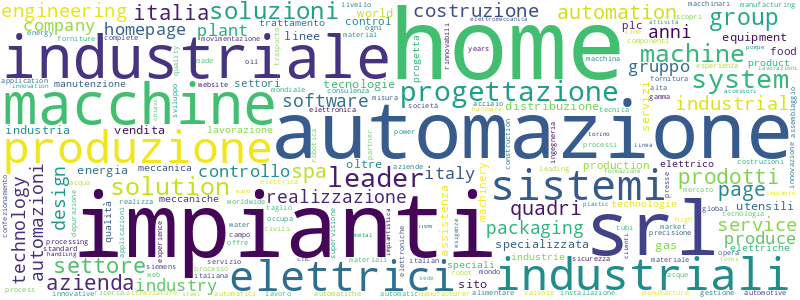

In [8]:
# Clients wordcloud
wc.WordCloud(background_color="white",
             repeat=False,
             collocations=False,
             width=800,
             height=300).generate(clientKeywords).to_image()

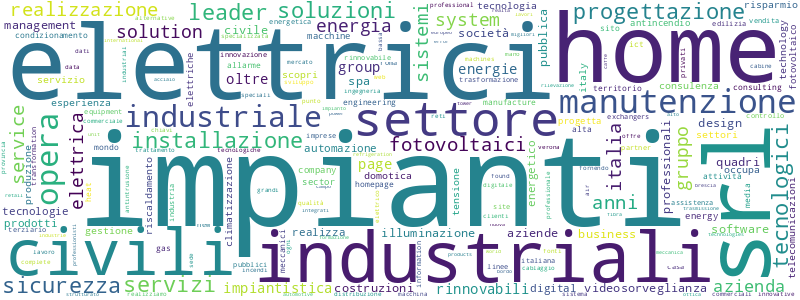

In [9]:
# Prospect wordcloud
wc.WordCloud(background_color="white",
             repeat=False,
             collocations=False,
             width=800,
             height=300).generate(prospectKeywords).to_image()

### A glimpse on the distribution

In [10]:
bt.plot_word_frequencies(prospectKeywords, title="Prospect word freq")

In [11]:
bt.plot_word_frequencies(clientKeywords, title="Client word freq")

### Let's normalize: stemming

In [12]:
keywordsNoStem = " ".join(df["Keywords"].tolist())
keywordsNoStem = bt.drop_duplicates(keywordsNoStem).split(" ")
len(keywordsNoStem)

13249

In [13]:
keywordsStem = " ".join(df["Keywords"].tolist())
keywordsStem = bt.stem_words(keywordsStem)
keywordsStem = bt.drop_duplicates(keywordsStem).split(" ")
len(keywordsStem)

9807

In [14]:
df["Keywords"] = df["Keywords"].apply(bt.stem_words)

## Modelling

In [88]:
import importlib
importlib.reload(bt)

res = bt.SSESTM(alpha_minus=0.5, 
                alpha_plus=0.5,
                kappa=10).fit(X = df_train["Keywords"], y = df_train["Orders"])

### Step 1: Feature selection

In [89]:
qgrid.show_grid(res.marginal_screening)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### Step 2: Topic modelling

In [90]:
test = pd.DataFrame({"S": res.marginal_screening["term"], 
                     "Op": res.topic_coefficients[:,0], 
                     "Om": res.topic_coefficients[:,1]})
qgrid.show_grid(test)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### Step 3: Scoring on webpage

In [91]:
test = df_train.iloc[range(1,10)]
test

Client                       WebPage  \
75         0       HTTP://WWW.HYPERTAC.COM   
440        0     HTTP://WWW.ELCOSITALIA.IT   
850        0         HTTP://WWW.ESOSRL.COM   
1568       1  HTTP://WWW.CDMENGINEERING.IT   
231        0   HTTP://WWW.IMP-ELECTRIC.COM   
3018       1       HTTP://WWW.KEYFROST.COM   
1792       1       HTTP://WWW.CUSINATO.COM   
1278       1        HTTP://WWW.BERCOSRL.IT   
421        0            HTTP://WWW.DICA.IT   

                                               Keywords        Orders  
75                                                           0.000000  
440   centr dat elabor elco elettr fum impiant indus...      0.000000  
850                                         eso hom srl      0.000000  
1568  arsiz bust cdm engin hom impiant mater plastic...  30414.506667  
231                                      electr imp srl      0.000000  
3018                                           keyfrost  23520.493333  
1792  cusin granular macchin miscel prodott produc s...   4039.583333  
1278  anni assistt cnc engin install macchin nuov re...   1288.700000  
421                                   cattol hom servic      0.000000

In [92]:
pred = res.predict(test["Keywords"])
pred

array([ 1, 10,  2,  7,  2,  1,  5, 14,  2])

## Applying the model

### Training-test split

In [21]:
from sklearn.model_selection import train_test_split

In [71]:
df_train, df_test = train_test_split(df, test_size=0.10, random_state=42)

In [26]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

In [49]:
parameters = {'alpha_minus': (0.5, 0.4)}

clf = GridSearchCV(bt.SSESTM(), parameters, scoring= "neg_mean_squared_error")

/usr/lib64/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/var/home/mrepetto94/Documenti/Google Drive/2.Projects/PhD/ECO repository/IV Term/Reading Groups/Python Programming/sentiment_modelling/beautifultools.py:422: RuntimeWarning:

divide by zero encountered in log



ValueError: operands could not be broadcast together with shapes (6536,1) (6490,1) 

In [50]:
clf.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
>>> parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
>>> svc = svm.SVC()
>>> clf = GridSearchCV(svc, parameters)
>>> clf.fit(iris.data, iris.target)
GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})
>>> sorted(clf.cv_results_.keys())
['mean_fit_time', 'mean_score_time', 'mean_test_score',...
 'param_C', 'param_kernel', 'params',...
 'rank_test_score', 'split0_test_score',...
 'split2_test_score', ...
 'std_fit_time', 'std_score_time', 'std_test_score']

### Crossvalidating parameters

### Out of sample model performance 

## Conclusion

In [35]:
from sklearn.linear_model import LinearRegression

In [40]:
LinearRegression(fit_intercept=True,normalize=False,copy_X=True).get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}